In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import QuantileTransformer
from scipy.stats import norm

import time
import pickle
from tqdm import tqdm
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
# import ptitprince as pt # it requires seaborn of version 0.11 to be installed, but version 0.12 is needed for utils_viz to work

from utils_data import TrueSampler
from utils_model import MLPDiffusionContinuous

from ddpm import MyDDPM, generate_samples, generate_imputation, generate_pass

import sys

sys.path.insert(0, "../tab-ddpm/pass-inference/syninf/")
from utils_viz import plot_distribution, compare_distributions_grid, heatmap_correlation
from utils_syninf import catboost_pred_model, test_rmse
from utils_num import calculate_fid, wasserstein_1_distance, wasserstein_2_distance


seed = 2024

In [3]:
# Initialization #

d_in = 8
d_time = 128
hidden_dims = [512, 256, 256, 256, 256, 128]
n_steps = 1000

device = "cuda:7"


noise_pred_network = MLPDiffusionContinuous(
    d_in=d_in, hidden_dims=hidden_dims, dim_t=d_time
)
tabular_ddpm = MyDDPM(network=noise_pred_network, n_steps=n_steps, device=device)


# Loading trained model for inference
tabular_ddpm.load_state_dict(torch.load("./ckpt/tabular_ddpm.pt"))

# Loading quantile transformer pipeline used during training
qt = joblib.load("./ckpt/qt_train.joblib")

# True sample
yx_true_unnorm = np.load("./data/yx.npy")
yx_true_norm = qt.transform(yx_true_unnorm)

In [78]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

column_names = ["Y", "X1", "X2", "X3", "X4", "X5", "X6", "X7"]


# Generate evaluation data #
n_eval = 3000
true_sampler = TrueSampler(sigma=0.2)
X, y, mean_y, sigma_x = true_sampler.sample(n_eval, return_mean=True)
yx_true_unnorm = np.concatenate([y[:, None], X], axis=1)
df_true_unnorm = pd.DataFrame(yx_true_unnorm, columns=column_names)


qt = QuantileTransformer(output_distribution="normal", random_state=seed)
qt.fit(yx_true_unnorm)
yx_true_norm = qt.transform(yx_true_unnorm)
df_true_norm = pd.DataFrame(yx_true_norm, columns=column_names)


# Generate synthetic data #
tau_list = [0, 0.2, 0.5, 1]
result_df_norm_list, result_df_unnorm_list = [df_true_norm], [df_true_unnorm]
for tau in tau_list:
    print(f"Generating samples with tau={tau} ...")
    yx_fake = generate_pass(
        tabular_ddpm,
        torch.tensor(yx_true_norm).float(),
        perturbation_size=tau,
        device=device,
    )
    yx_fake_norm = yx_fake.cpu().detach().numpy()
    yx_fake_unnorm = qt.inverse_transform(yx_fake_norm)

    df_fake_norm = pd.DataFrame(yx_fake_norm, columns=column_names)
    result_df_norm_list.append(df_fake_norm)

    df_fake_unnorm = pd.DataFrame(yx_fake_unnorm, columns=column_names)
    result_df_unnorm_list.append(df_fake_unnorm)

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/tmp/ipykernel_9219/2774312245.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 13.36 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.05 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.13 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.88 seconds.


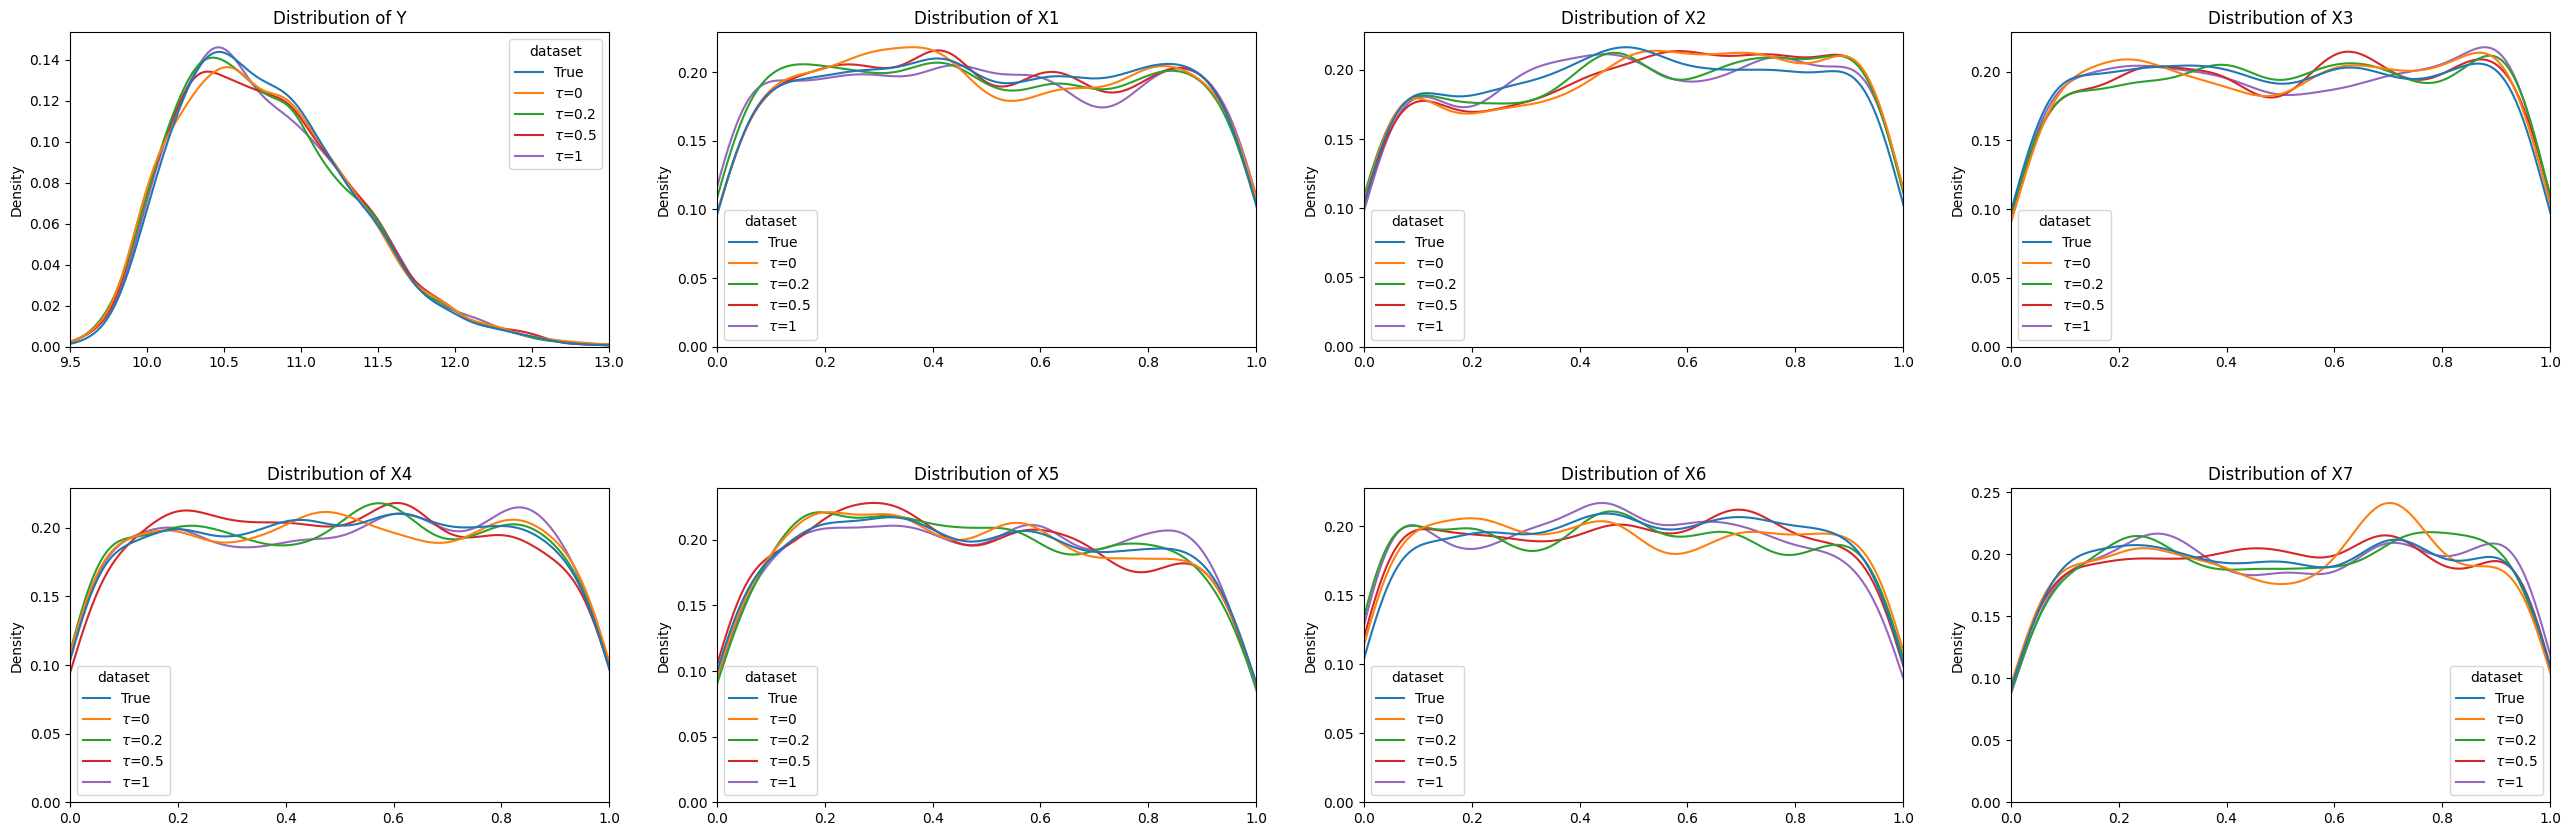

In [80]:
# Evaluate the fidelity of the fake sample #

plt.style.use("default")
compare_distributions_grid(
    result_df_unnorm_list,
    ["True"] + [rf"$\tau$={tau}" for tau in tau_list],
    nrows=2,
    ncols=4,
)

In [4]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

D = 20 # Monte Carlo sizes
column_names = ["Y", "X1", "X2", "X3", "X4", "X5", "X6", "X7"]


# Generate evaluation data #
n_eval = 3000
true_sampler = TrueSampler(sigma=0.2)
X, y, mean_y, sigma_x = true_sampler.sample(n_eval, return_mean=True)
yx_true_unnorm = np.concatenate([y[:, None], X], axis=1)
df_true_unnorm = pd.DataFrame(yx_true_unnorm, columns=column_names)


qt = QuantileTransformer(output_distribution="normal", random_state=seed)
qt.fit(yx_true_unnorm)
yx_true_norm = qt.transform(yx_true_unnorm)
df_true_norm = pd.DataFrame(yx_true_norm, columns=column_names)


# Repeated experiment to get distributional distances #
dist_metrics = {
    "fid": [],
    "w1": [],
    "w2": [],
}
tau_list = [0, 0.2, 0.5, 1]
for d in tqdm(range(D)):
    X, y, mean_y, sigma_x = true_sampler.sample(n_eval, return_mean=True)
    yx_true_unnorm_copy = np.concatenate([y[:, None], X], axis=1)
    df_true_unnorm_copy = pd.DataFrame(yx_true_unnorm_copy, columns=column_names)
    yx_true_norm_copy = qt.transform(yx_true_unnorm_copy)
    df_true_norm_copy = pd.DataFrame(yx_true_norm_copy, columns=column_names)

    result_df_norm_list = [df_true_norm_copy]
    result_df_unnorm_list = [df_true_unnorm_copy]
    for tau in tau_list:
        print(f"Generating samples with tau={tau} ...")
        yx_fake = generate_pass(
            tabular_ddpm,
            torch.tensor(yx_true_norm).float(),
            perturbation_size=tau,
            device=device,
        )
        yx_fake_norm = yx_fake.cpu().detach().numpy()
        yx_fake_unnorm = qt.inverse_transform(yx_fake_norm)

        df_fake_norm = pd.DataFrame(yx_fake_norm, columns=column_names)
        result_df_norm_list.append(df_fake_norm)

        df_fake_unnorm = pd.DataFrame(yx_fake_unnorm, columns=column_names)
        result_df_unnorm_list.append(df_fake_unnorm)
    
    for temp_df in result_df_norm_list:
        dist_metrics["fid"].append(calculate_fid(df_true_norm, temp_df))
        dist_metrics["w1"].append(wasserstein_1_distance(df_true_norm, temp_df))
        dist_metrics["w2"].append(wasserstein_2_distance(df_true_norm, temp_df))
        
        pickle.dump(dist_metrics, open("./result/dist_metrics.pkl", "wb"))
    

X shape:  (3000, 7)
y shape:  (3000,)


  0%|          | 0/20 [00:00<?, ?it/s]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 13.80 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.20 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.10 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 13.64 seconds.


  5%|▌         | 1/20 [01:53<35:50, 113.20s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 14.06 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.82 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.03 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.97 seconds.


 10%|█         | 2/20 [03:46<33:58, 113.24s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 14.16 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.94 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.13 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.43 seconds.


 15%|█▌        | 3/20 [05:39<32:02, 113.11s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 14.39 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.65 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.21 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 13.27 seconds.


 20%|██        | 4/20 [07:32<30:10, 113.18s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 13.87 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 15.15 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.35 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.53 seconds.


 25%|██▌       | 5/20 [09:25<28:18, 113.21s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 14.22 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.90 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.23 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.95 seconds.


 30%|███       | 6/20 [11:19<26:27, 113.36s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 14.32 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.88 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.09 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.83 seconds.


 35%|███▌      | 7/20 [13:12<24:31, 113.19s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 14.28 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.66 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.16 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 13.04 seconds.


 40%|████      | 8/20 [15:05<22:38, 113.19s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 14.24 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.76 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.03 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.88 seconds.


 45%|████▌     | 9/20 [16:59<20:46, 113.29s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 14.06 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.87 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.45 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.99 seconds.


 50%|█████     | 10/20 [18:52<18:53, 113.35s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 14.51 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.71 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.30 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 13.11 seconds.


 55%|█████▌    | 11/20 [20:46<17:02, 113.64s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 14.41 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.59 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.43 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 13.09 seconds.


 60%|██████    | 12/20 [22:40<15:08, 113.55s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 14.32 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 15.16 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.05 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.67 seconds.


 65%|██████▌   | 13/20 [24:32<13:12, 113.27s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 13.97 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.65 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 13.95 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 13.57 seconds.


 70%|███████   | 14/20 [26:25<11:19, 113.19s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 13.71 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.75 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 13.83 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.61 seconds.


 75%|███████▌  | 15/20 [28:17<09:23, 112.77s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 13.87 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.62 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 13.45 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.84 seconds.


 80%|████████  | 16/20 [30:09<07:29, 112.39s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 13.80 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.30 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.24 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.74 seconds.


 85%|████████▌ | 17/20 [32:01<05:36, 112.24s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 13.26 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.33 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 13.79 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.77 seconds.


 90%|█████████ | 18/20 [33:51<03:43, 111.57s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 13.54 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 14.68 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 13.27 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.68 seconds.


 95%|█████████▌| 19/20 [35:42<01:51, 111.43s/it]

X shape:  (3000, 7)
y shape:  (3000,)
Generating samples with tau=0 ...
Begin matching ranks ...


/home/liu00980/Documents/multimodal/tabular/conditional/ddpm.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Rank matching done in 14.13 seconds.


Generating samples with tau=0.2 ...
Begin matching ranks ...
Rank matching done in 13.94 seconds.


Generating samples with tau=0.5 ...
Begin matching ranks ...
Rank matching done in 14.09 seconds.


Generating samples with tau=1 ...
Begin matching ranks ...
Rank matching done in 12.56 seconds.


100%|██████████| 20/20 [37:33<00:00, 112.67s/it]


In [10]:
for k in dist_metrics.keys():
    dist_array = np.array(dist_metrics[k]).reshape(20, 5)
    dist_mean = np.mean(dist_array, axis=0)
    dist_std = np.std(dist_array, axis=0)
    print(k)
    print(dist_mean)
    print(dist_std)

fid
[0.02038999 0.0239181  0.02263919 0.02347441 0.02437637]
[0.00316695 0.0051227  0.00460842 0.00548647 0.00366538]
w1
[1.2440251  1.2377525  1.23653895 1.23799346 1.23816885]
[0.00558123 0.00442841 0.0044719  0.00529149 0.00505717]
w2
[1.31392157 1.29769323 1.29569504 1.29845478 1.2979801 ]
[0.00708746 0.00456259 0.00440619 0.00543117 0.0056689 ]
